# DME project - Exploratory data analysis section
This notebook contains the exploratory data analysis performed on the `recipes.csv` data file from Bellosi (2011)

In [2]:
# Display plots inline
%matplotlib inline

# Data libraries

import pandas as pd
import numpy as np
import geopandas as gp

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# Misc libraries
import os
import time
from datetime import date

# Scipy libraries
import scipy.stats as stats   # Imports the entire scipy.stats (all distributions)
from scipy.stats import norm

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# UMAP
import umap.umap_ as umap

# Heatmap 
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 

# Helper script
import get_recipe as gr

## Data preparation

In [3]:
# Get datasets

recipes_df, cuisines_df = gr.get_data()

In [6]:
# Inner join to see the cuisine name
recipes_cuisine = pd.merge(recipes_df, cuisines_df, on = "cuisine", how = "inner")
recipes_cuisine

,acorn_squash,adobo,african_birdseye_chile_pepper,ale,aleppo_pepper,alfalfa_sprouts,alfredo_sauce,allspice,almond,almond_butter,...,yellow_curry_paste,yellow_food_coloring,yellow_split_pea,yellow_squash,yogurt,zaatar,zest,zucchini,cuisine,cuisine_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chinese
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chinese
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chinese
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chinese
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chinese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,Thai
4232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,Thai
4233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,Thai
4234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,Thai


## Exploratory data analysis
### Split dataset

In [127]:
train, val = train_test_split(recipes_df, test_size=0.3, random_state=42, stratify=recipes_df['cuisine'])
val, test = train_test_split(val, test_size=(1/3), random_state=42, stratify=val['cuisine'])
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
print(f'Percentage of train examples: {round(len(train) / len(recipes_df)*100)}%')
print(f'Percentage of validation examples: {round(len(val) / len(recipes_df)*100)}%')
print(f'Percentage of test examples: {round(len(test) / len(recipes_df)*100)}%')

2965 train examples
847 validation examples
424 test examples
Percentage of train examples: 70%
Percentage of validation examples: 20%
Percentage of test examples: 10%


### Visual data analysis

In [128]:
# Inner join to see the cuisine name
recipes_vis = pd.merge(train, cuisines_df, on = "cuisine", how = "inner")

# Create a new column where the ingredients used per recipe are summed
recipes_vis["ingredient_count"] =  recipes_vis.drop('cuisine', axis=1).sum(axis=1)

# Descriptive statistics
recipes_vis["ingredient_count"].describe()

count    2718.000000
mean       10.771155
std         3.748913
min         3.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        26.000000
Name: ingredient_count, dtype: float64

### Cuisine analysis

In [133]:
# Get the most popular ingredients in recipes
sums = pd.DataFrame(recipes_df.drop(columns =["cuisine"]).sum(axis = 0), columns = ["counter"])

In [135]:
# Top 10 ingredients
sums.sort_values(ascending = False, by = "counter").head(10).T

,garlic,onion,olive_oil,salt,chicken,pepper,tomato,water,ginger,butter
counter,2340,2157,1390,1382,1324,1147,953,894,855,788


In [137]:
# Top 10 least popular ingredients
sums.sort_values(ascending = False, by = "counter").tail(10).T

,mustard_oil,nigella_seeds,papaya,parchment_paper,pastry_dough,bagel,pierogi,pomegranate,ponzu,nectarine
counter,1,1,1,1,1,1,1,1,1,1


### Cuisine analysis

In [138]:
# Group by cuisine
cuisine_recipes = pd.DataFrame({'recipes': recipes_vis.groupby
                                (["cuisine", "cuisine_name", "ingredient_count"]).
                                size()}).reset_index()


<AxesSubplot:xlabel='cuisine_name', ylabel='ingredient_count'>

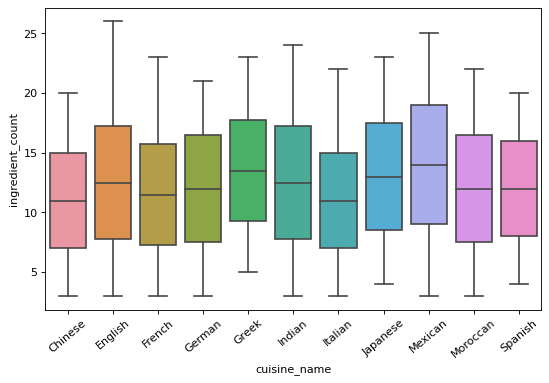

In [139]:
# Box plots for each cuisine type

cuisines_bplot = sns.boxplot(x = "cuisine_name", y = "ingredient_count", data = cuisine_recipes, whis = 1.5)
cuisines_bplot.set_xticklabels(cuisines_bplot.get_xticklabels(), rotation=40)
cuisines_bplot

### Most frequent ingredients per cuisine

In [140]:
# Top n ingredients per cuisine

def top_ingredients(n):

    grouped_recipes = recipes_df.groupby("cuisine").sum()
    number_cuisines = grouped_recipes.shape[0]

    ingr_dict = {}

    for i in range(0, number_cuisines):

        ocurrences = grouped_recipes.loc[i].sort_values(ascending = False).reset_index().iloc[0:n]
        ocurrences.columns = ["ingredient", "ocurrence"]
        top = ocurrences["ingredient"].to_list()
        ingr_dict[f"{i}"] = top

    top_ingr_df = pd.DataFrame(data = ingr_dict)

    return top_ingr_df

In [141]:
test = top_ingredients(10)
test.columns = ['Chinese', 'English', 'French', 'German', 'Greek', 'Indian', 'Italian', 'Japanese', 'Mexican', 'Moroccan', 'Spanish', 'Thai']
test

,Chinese,English,French,German,Greek,Indian,Italian,Japanese,Mexican,Moroccan,Spanish,Thai
0,soy_sauce,onion,garlic,onion,olive_oil,onion,garlic,soy_sauce,onion,onion,garlic,garlic
1,garlic,butter,butter,pepper,garlic,garlic,olive_oil,rice_wine,tortilla,garlic,olive_oil,fish_sauce
2,ginger,potato,wine,salt,onion,ginger,parmesan_cheese,sugar,garlic,olive_oil,onion,chicken
3,cornstarch,garlic,onion,flour,oregano,cumin,onion,ginger,cumin,cumin,tomato,coconut_milk_or_cream
4,green_onion,flour,olive_oil,water,tomato,turmeric,pasta,garlic,salt,cinnamon,chicken,lime
5,chicken,olive_oil,salt,butter,pepper,salt,salt,green_onion,chicken,chicken,sweet_pepper,ginger
6,vegetable_oil,carrot,pepper,egg,feta_cheese,coriander,basil,water,chili_powder,salt,pepper,soy_sauce
7,sugar,beef,chicken,pork,salt,tomato,tomato,onion,tomato,ginger,paprika,cilantro
8,sesame_oil,chicken,thyme,bacon,lemon_juice,vegetable_oil,parsley,vegetable_oil,beef,pepper,salt,vegetable_oil
9,water,parsley,flour,beef,parsley,chicken,pepper,chicken,chile_pepper,parsley,rice,green_onion


### Specific ingredients heatmap

In [142]:
def specific_ingredients(df):

    grouped_recipes = df.groupby("cuisine").sum().reset_index()
    recipes_feats = df.drop(columns = "cuisine")

    ocur = []
    spec_ingr = []
    cuisine = []

    for i in recipes_feats.columns:
        a = grouped_recipes[["cuisine", i]].where(grouped_recipes[i] >0).dropna()

        if a.shape[0] == 1:
            cuisine.append(a["cuisine"].iloc[0])
            ocur.append(a[i].iloc[0])
            spec_ingr.append(i)
    
    specific_df = pd.DataFrame(data = zip(spec_ingr, cuisine, ocur), columns = ["ingredient", "cuisine", "occurrence"])

    return specific_df

In [143]:
spec = specific_ingredients(recipes_df)
spec_names = pd.merge(spec, cuisines_df, on = "cuisine", how = "inner")
spec

,ingredient,cuisine,occurrence
0,ale,1.0,5.0
1,aleppo_pepper,4.0,1.0
2,almond_butter,11.0,1.0
3,amaretti,6.0,1.0
4,amchoor_powder,5.0,6.0
...,...,...,...
168,white_cheese,3.0,1.0
169,yams,9.0,1.0
170,yellow_curry_paste,11.0,3.0
171,yellow_food_coloring,0.0,1.0


In [144]:
# Create a temporary dataframe for holding the country names for each cuisine in the dataset
countries = ['UK', 'Greece', 'Thailand', 'Italy', 'India', 'Spain', 'Germany', 'Morocco', 'Mexico', 'Japan', 'France', 'China']
countries_adjective = ['English', 'Greek', 'Thai', 'Italian', 'Indian', 'Spanish', 'German', 'Moroccan', 'Mexican', 'Japanese', 'French', 'Chinese']

countries_df = pd.DataFrame(data= zip(countries, countries_adjective), columns = ["country", "cuisine_name"])

In [145]:
spec_countries = pd.merge(spec_names, countries_df, how = "inner", on = "cuisine_name")
heat_map = spec_countries.groupby("country").count().reset_index()

In [146]:
# Heatmap dictionaries 
data = dict(type='choropleth',
           locations = heat_map['country'],
            locationmode = "country names",
           z = heat_map['occurrence'],
           text = heat_map['country'],
           colorbar = {'title' : 'Specific ingredients'},
           colorscale = "YlOrRd",
           zmax = heat_map["occurrence"].max(),
           zmin = heat_map["occurrence"].min()
           )
layout = dict(
    autosize=True,
    width=1000,
    height=700,
    title = 'Specific ingredients per country',
    geo = dict(
        showframe = False,
        projection = {'type':'natural earth'}
    )
)

Possible projections: 'equirectangular', 'kavrayskiy7', 'miller', 'robinson', 'eckert4', 'azimuthal equal area', 'azimuthal equidistant', 'conic equal area', 'conic conformal', 'conic equidistant', 'gnomonic', 'stereographic', 'mollweide', 'hammer', 'transverse mercator', 'albers usa', 'winkel tripel', 'aitoff', 'sinusoidal'

In [148]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap,validate=False)

## Dimensionality reduction
### Remove ingredients that only appear once or twice in a recipe

In [149]:
least_pop_ing = sums.loc[sums["counter"] <= 2].reset_index()["index"].to_list()

In [ ]:
# Remove least popular ingredients (appearing only once or twice in recipes)

train_clean = train.copy().drop(columns = least_pop_ing)

### PCA

In [ ]:
# get data ready for PCA

pca_df = pd.merge(train_clean, cuisines_df, on = "cuisine", how = "inner")

X = pca_df.drop(columns = ["cuisine", "cuisine_name"])
y = pca_df["cuisine"]
y_name = pca_df["cuisine_name"]

In [ ]:
# PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)
pca_df['pca-one-d'] = pca_result[:,0]
pca_df['pca-two-d'] = pca_result[:,1] 
pca_df['pca-three-d'] = pca_result[:,2]
print(f'Explained variation per principal component: {pca.explained_variance_ratio_}')

In [ ]:
spec_names["cuisine_name"].unique()

## Preparing data for TD-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
 

In [ ]:
mallet_columns = [f"ingredient{i}" for i in range(1, 32)] # found that 31 ingredients was the most in any one recipe
mallet_columns.insert(0, "recipe_id")
mallet_columns.insert(1, "cuisine_id")

mallet_df = pd.read_table(malletFile, delimiter=",", header=None, names=mallet_columns)

mallet_df = mallet_df.replace(' ', '_', regex=True) # remove white space and replace with underscore
mallet_df = mallet_df.apply(lambda x: x.astype(str).str.lower()) # convert all strings to lower case 
mallet_df['recipe_id'] = pd.to_numeric(mallet_df['recipe_id']) # converting these columns back to numeric (previous stage converts them to 'object')
mallet_df['cuisine_id'] = pd.to_numeric(mallet_df['cuisine_id'])

mallet_df

In [ ]:
#recipe_cuisine_dict = recipes_df["cuisine"].to_dict()

In [ ]:
# create dictionary for the recipes
recipe_cuisine_dict = {}
recipe_id_dict={}
mallet_dict={}

mallet_under = os.path.join(filePath, "recipes-mallet-under.txt")
with open(mallet_under, 'r') as f:
        for line in f:
            splitLine = line.split(sep =",")
            ingr = [",".join(splitLine[2:]).strip('\n')]
            recipe_id_dict[int(splitLine[0])] = ingr

In [ ]:
mallet_id = recipes_df[["cuisine"]].reset_index()
mallet_id.columns = ["id", "cuisine"]
mallet_id["id"] = mallet_id["id"]+1

In [ ]:
recipes_df.reset_index()

mallet = pd.DataFrame(data=((key, recipe) for key, content in recipe_id_dict.items() for recipe in content), columns =["id", "recipe"])
mallet = pd.merge(mallet, mallet_id, on = "id", how = "inner")
mallet

In [ ]:
# Test for chinese
chinese = mallet[mallet.cuisine == 0]
print(chinese)

In [ ]:
vectorizer = TfidfVectorizer()
doc_vec = vectorizer.fit_transform(chinese["recipe"])

In [ ]:
#doc_vec
not_sure_df = pd.DataFrame(doc_vec.toarray().transpose(), index = vectorizer.get_feature_names())

values_tfidf = not_sure_df.values.flatten()
values_tfidf = values_tfidf[values_tfidf != 0]
values_tfidf = np.sort(-values_tfidf)
len(values_tfidf)

In [ ]:
not_sure_df

In [ ]:
cos_sim = cosine_similarity(X = not_sure_df.T, Y = not_sure_df.T)

In [ ]:
cos_sim.max()

In [ ]:
cos_sim_df = pd.DataFrame(data = cos_sim)
cos_sim_df